# Figure 1: fingerprint example, pathway similarity example, biosynthetic distance results

In [160]:
from pathlib import Path

import pandas as pd
from rdkit import Chem

from biosynfoni.moldrawing import draw, _get_highlight_loc_and_col

mol = Chem.SDMolSupplier(f'{Path().home()}/article_bsf/data/input/coconut.sdf')[1]
# draw(mol, _get_highlight_loc_and_col(mol))

# Figure 2: Applicability domain - calculation times, coverage, substructure distribution

In [23]:
from pathlib import Path

import numpy as np  
# import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem


sdf_path = f"{Path().home()}/article_bsf/data/input/coconut.sdf"

def sizes(sdf_path) -> np.array:
    return np.array([mol.GetNumHeavyAtoms() for mol in Chem.SDMolSupplier(sdf_path)])

def times(fp_name) -> np.array:
    return np.loadtxt(f"{Path().home()}/article_bsf/coconut_{fp_name}_times.csv", delimiter=",", dtype=float)

def time_size_stats(times, sizes) -> np.array:
    """
    Function to get the data per fingerprint
    """
    assert len(times) == len(sizes), "The length of times and sizes should be the same"
    
    unique_sizes = np.unique(sizes)

    average_times = []
    for size in unique_sizes:
        average_times.append(np.mean(times[sizes == size]))

    std_times = []
    for size in unique_sizes:
        std_times.append(np.std(times[sizes == size]))

    return np.array([(size, avg_time, std_time) for size, avg_time, std_time in zip(unique_sizes, average_times, std_times)], 
                    dtype=[('size', int), ('average_time', float), ('std_time', float)])



In [24]:
sizes = sizes(sdf_path)

[11:51:30] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 33 ignored
[11:51:31] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 17 ignored
[11:51:34] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 14 ignored
[11:51:39] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 33 ignored
[11:51:40] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 38 ignored
[11:51:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 42 ignored
[11:51:52] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 85 ignored
[11:51:52] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 82 ignored
[11:51:53] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 81 ignored
[11:51:53] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 78 ignored
[11:51:53] Warning: ambiguous stereochemistry - zero final chira

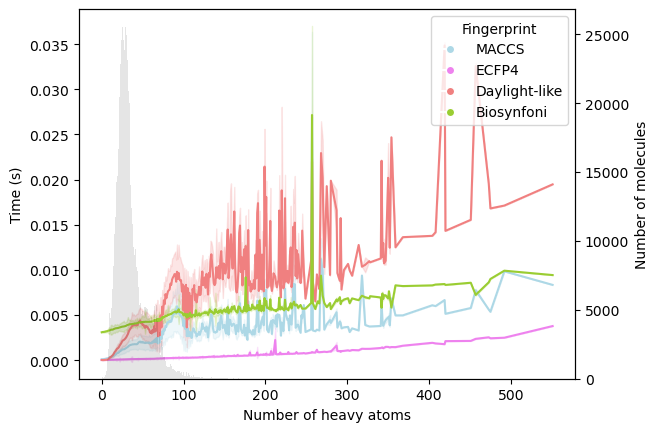

In [175]:
# x axis coconut size, y axis time, line through averages per size, a 50% confidence interval around the line
fp_colour = {"maccs": "lightblue", "morgan": "violet", "rdk": "lightcoral", "bsf": "yellowgreen"}
for fp_name, colour in fp_colour.items():
    # plt.scatter(sizes, times(fp_name), s=1, color=colour, alpha=0.1)
    plt.xlabel("Number of heavy atoms")
    plt.ylabel("Time (s)")

    # plot the average time per size
    
    data = time_size_stats(times(fp_name), sizes)
    plt.plot(data["size"], data["average_time"], color=colour)

    # plot the 50% confidence interval around the average time per size
    plt.fill_between(
        data["size"],
        data["average_time"] - 0.5 * data["std_time"],
        data["average_time"] + 0.5 * data["std_time"],
        color=colour,
        alpha=0.2,
    )

# plot the sizes behind it with the y axis on the right
plt.twinx()
# as a histogram
plt.hist(sizes, bins=np.linspace(0, data["size"].max(), data["size"].max()), alpha=0.1, color="black")
plt.ylabel("Number of molecules")


# make handles for the legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colour, label=actual_names[fp_name]) for fp_name, colour in fp_colour.items()]
plt.legend(handles=handles, title="Fingerprint")

plt.show()

# density plot of am

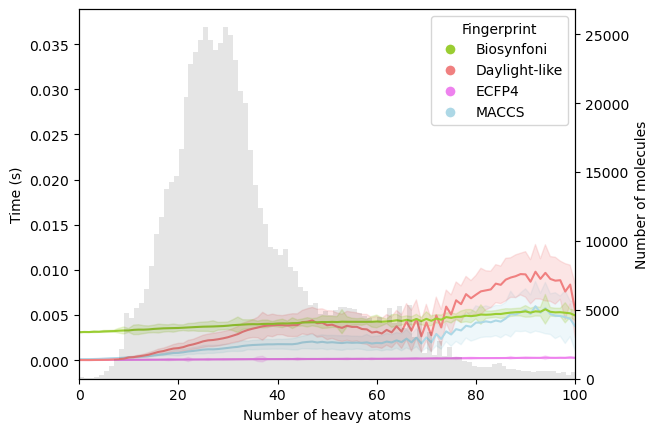

In [174]:
# x axis coconut size, y axis time, line through averages per size, a 50% confidence interval around the line
fp_colour = {"maccs": "lightblue", "morgan": "violet", "rdk": "lightcoral", "bsf": "yellowgreen"}
actual_names = {"maccs": "MACCS", "morgan": "ECFP4", "rdk": "Daylight-like", "bsf": "Biosynfoni"}
for fp_name, colour in fp_colour.items():
    # plt.scatter(sizes, times(fp_name), s=1, color=colour, alpha=0.1)
    plt.xlabel("Number of heavy atoms")
    plt.ylabel("Time (s)")

    # plot the average time per size
    
    data = time_size_stats(times(fp_name), sizes)

    plt.plot(data["size"], data["average_time"], color=colour)
    

    # plot the 50% confidence interval around the average time per size
    plt.fill_between(
        data["size"],
        data["average_time"] - 0.5 * data["std_time"],
        data["average_time"] + 0.5 * data["std_time"],
        color=colour,
        alpha=0.2,
    )

# plot the sizes behind it with the y axis on the right
plt.twinx()
# as a histogram
plt.hist(sizes, bins=np.linspace(0, data["size"].max(), data["size"].max()), alpha=0.1, color="black")
plt.ylabel("Number of molecules")


# make handles for the legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colour, markersize=8, label=actual_names[fp_name]) for fp_name, colour in fp_colour.items()]
handles.reverse()
plt.legend(handles=handles, title="Fingerprint")

# show x only until 100
plt.xlim(0, 100)

plt.show()

# density plot of am

In [166]:
print(np.average(times("maccs")))
print(np.average(times("morgan")))
print(np.average(times("rdk")))
print(np.average(times("bsf")))

0.0014902574219176983
9.979041091669671e-05
0.002816164522790954
0.003916785085435282


In [ ]:
# Figure 3: Applications - unsupervised clustering, supervised classification, biosynthetic pathway reconstruction

# Supplementary

## Figure 1 - Chemical space of datasets

In [92]:
from pathlib import Path


import pandas as pd
import numpy as np
from rdkit import Chem
import seaborn as sns

import umap



In [82]:

maccs_path = f"{Path().home()}/article_bsf/coconut_maccs.csv"
maccs = np.loadtxt(maccs_path, delimiter=",", dtype=int)
label = pd.read_csv(f"{Path().home()}/article_bsf/data/raw_data/coconut_complete-10-2024.csv")


/var/folders/qm/fzt72bc53hq6hhbj3wfljp5w0000gn/T/ipykernel_76892/2966178871.py:3: DtypeWarning: Columns (38,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  label = pd.read_csv(f"{Path().home()}/article_bsf/data/raw_data/coconut_complete-10-2024.csv")


In [104]:
# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
random_subset = np.random.choice(maccs.shape[0], 10000, replace=False)
subset_maccs = maccs[random_subset]
subset_labels = label.iloc[random_subset]


In [ ]:

embedding = reducer.fit_transform(subset_maccs)

<Axes: >

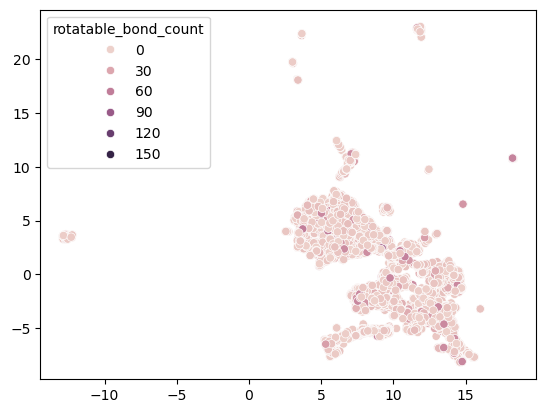

In [121]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=subset_labels["rotatable_bond_count"])#,  legend="full")

/Applications/anaconda3/envs/bsf_ext/lib/python3.12/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


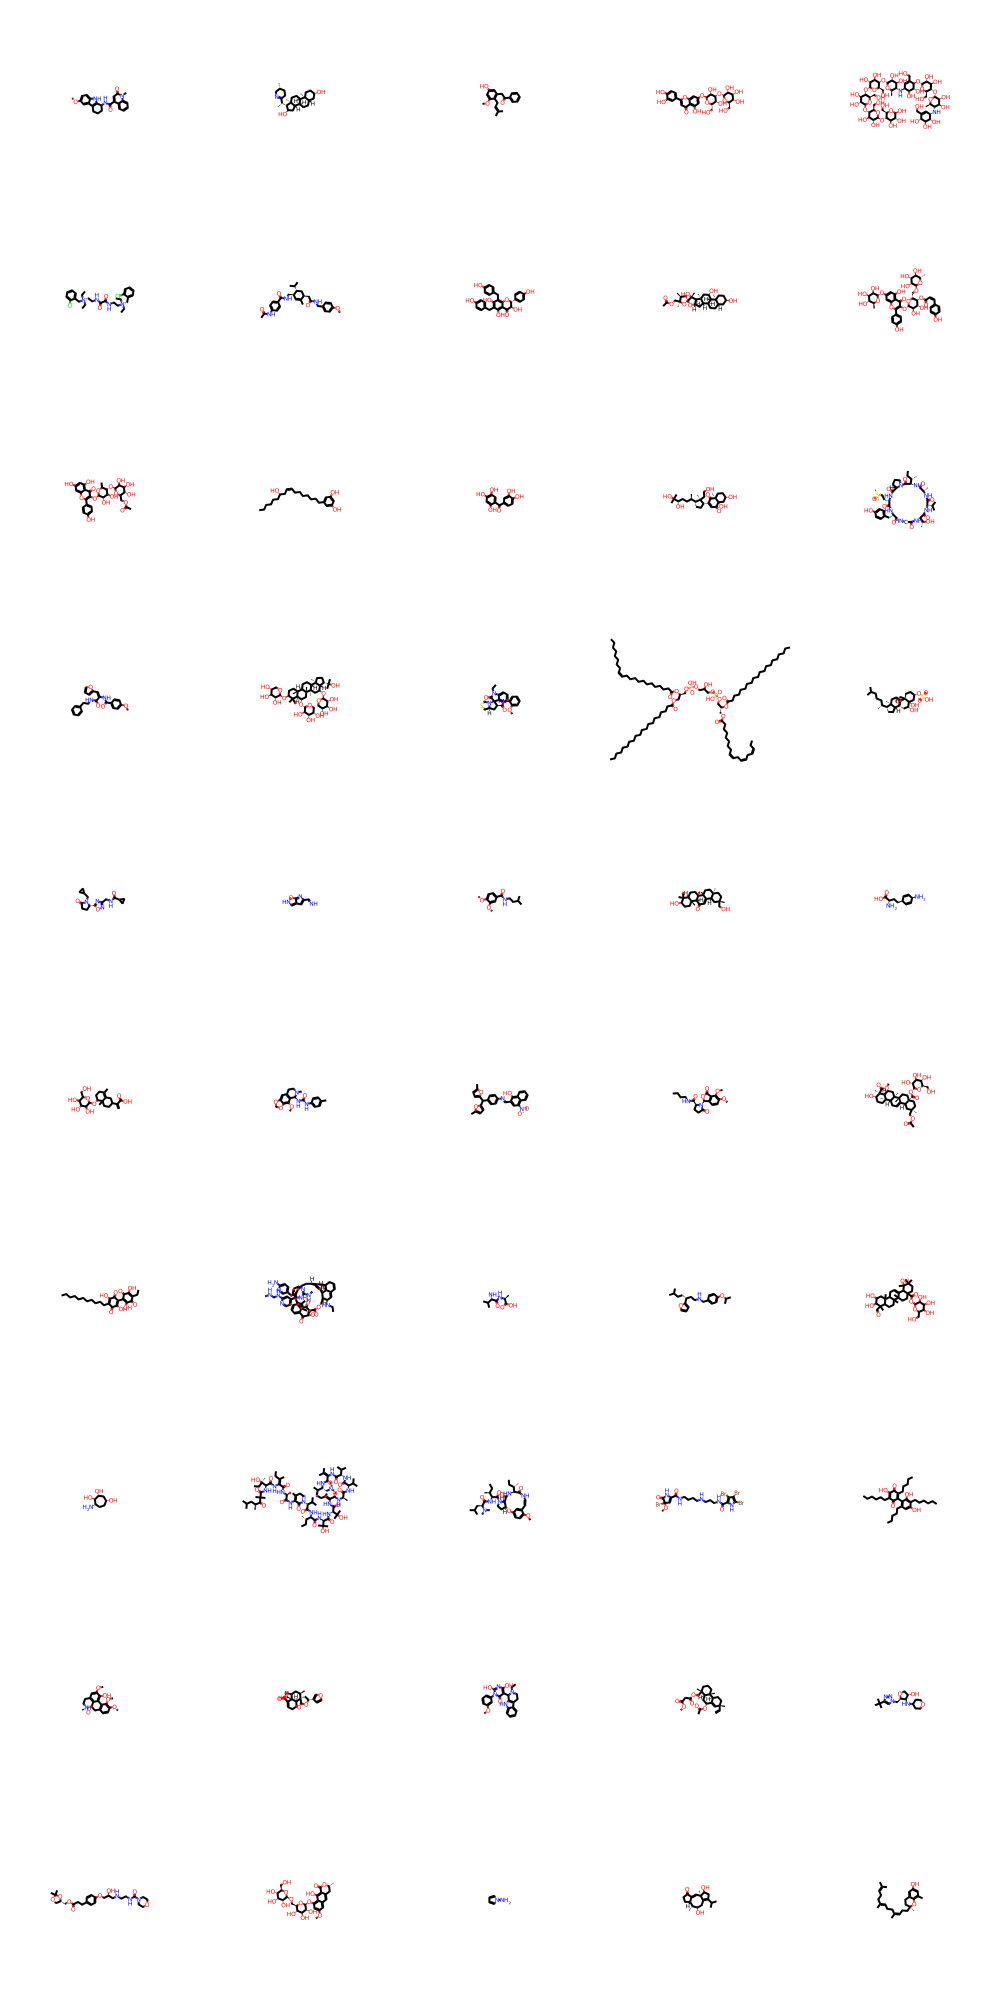

In [136]:
# get the indices of points that have embedding x < -10 and 0 < y < 5
points = embedding[(embedding[:, 0] < -10) & (0 < embedding[:, 1]) & (embedding[:, 1] < 5)]
indices = np.where((embedding[:, 0] < -10) & (0 < embedding[:, 1]) & (embedding[:, 1] < 5))[0]



of_interest = subset_labels.iloc[indices]

# draw molecules from smiles
mols = [Chem.MolFromSmiles(smiles) for smiles in of_interest["canonical_smiles"]]

Chem.Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))


In [52]:
# plot the molecules corresponding to the close points
sdf = Chem.SDMolSupplier(sdf_path)

for i, j in zip(*close_points):
    mol_i = sdf[int(random_subset[i][0])]
    mol_j = sdf[int(random_subset[j][0])]
    break
mol_i, mol_j

(<rdkit.Chem.rdchem.Mol at 0x1779a51c0>,
 <rdkit.Chem.rdchem.Mol at 0x1779a4e40>)

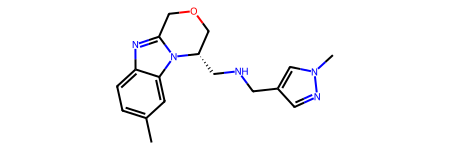

In [53]:
mol_i

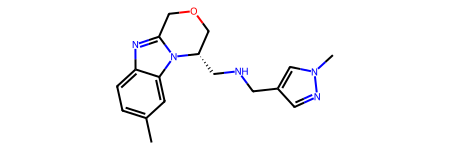

In [54]:
mol_j